## Run the Self-Organizing Map
Training sample: KiDS <br>
Labeling sample: GAMA <br>
___

First, load the data

In [58]:
from astropy.io import fits
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

plt.rcParams.update({
    'font.family'      : 'serif',
    'font.size'        : 24,
    'font.serif'       : 'Georgia',
    'axes.labelsize'   : 'large',
    'mathtext.fontset' : 'stix',
    'axes.linewidth'   :  1.5,
    'xtick.direction'  : 'in',
    'ytick.direction'  : 'in',
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

In [59]:
#Load in KiDS data
with fits.open('/data2/lsajkov/mpdg/data_products/KiDS/KiDS_SOM_catalog_18Jul24.fits') as cat:
    KiDS_cat = Table(cat[1].data)

#Load in GAMA data
with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_17Jul24.fits') as cat:
    GAMA_cat = Table(cat[1].data)

In [105]:
#Select the needed data
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_redshift_cut = KiDS_cat['redshift'] < 0.4
KiDS_size_cut = KiDS_cat['half_light_radius'] < 5

input_cat = KiDS_cat[KiDS_redshift_cut & KiDS_mag_cut & KiDS_size_cut]

GAMA_mag_cut = GAMA_cat['r_mag'] < 20.5
GAMA_redshift_cut = GAMA_cat['redshift'] < 0.4
GAMA_size_cut = GAMA_cat['half_light_radius'] < 5

labels_cat = GAMA_cat[GAMA_redshift_cut & GAMA_mag_cut & GAMA_size_cut]

input_data = Table([
                    input_cat['r_mag'],
                    # (input_cat['r_mag'] - input_cat['r_mag'].min())/(input_cat['r_mag'].max() - input_cat['r_mag'].min()),
                    input_cat['ug_col'],
                    input_cat['gr_col'],
                    input_cat['ri_col'],
                    # input_cat['half_light_radius']
                    input_cat['redshift']
                    ],
            names = [
                     'r_mag',
                     'ug_col',
                     'gr_col',
                     'ri_col',
                    #  'radius',
                     'redshift'
                     ])
input_stds = Table([
                    input_cat['r_mag_err'],
                    input_cat['ug_col_err'],
                    input_cat['gr_col_err'],
                    input_cat['ri_col_err'],
                    # input_cat['half_light_radius']/20
                    input_cat['redshift_err']
                    ],
           names = [
                    'r_mag_err',
                    'ug_col_err',
                    'gr_col_err',
                    'ri_col_err',
                    # 'radius_err'
                    'redshift_err'
                    ])

for key in input_stds.keys(): input_stds[key] = np.sqrt(input_stds[key])

input_labels = Table([
                      labels_cat['r_mag'],
                      # (labels_cat['r_mag'] - labels_cat['r_mag'].min())/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()),
                      labels_cat['ug_col'],
                      labels_cat['gr_col'],
                      labels_cat['ri_col'],
                      # labels_cat['half_light_radius'],
                      labels_cat['redshift'],
                      labels_cat['mstar'],
                      labels_cat['redshift'],
                      ],
             names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      # 'radius',
                      'redshift',
                      'mstar',
                      'pred_redshift'
                      ])

input_label_stds = Table([
                          labels_cat['r_mag_err'],
                          labels_cat['ug_col_err'],
                          labels_cat['gr_col_err'],
                          labels_cat['ri_col_err'],
                          # labels_cat['half_light_radius']/20,
                          [0.01] * len(labels_cat),
                          labels_cat['mstar_err'],
                        #   labels_cat['mstar_err']/(labels_cat['mstar'] * np.log(10)),
                          [0.01] * len(labels_cat),
                          ],
                 names = [
                          'r_mag_err',
                          'ug_col_err',
                          'gr_col_err',
                          'ri_col_err',
                          # 'radius_err',
                          'redshift_err',
                          'mstar_err',
                          'pred_redshift_err'
                          ])

# for key in input_label_stds.keys(): input_label_stds[key] = np.sqrt(input_label_stds[key]) 

print(f'Len of input data: {len(input_data)}')
print(f'Len of labeling data: {len(input_labels)}')

Len of input data: 626112
Len of labeling data: 46549


Select & normalize data

In [ ]:
#Select the needed data NORMALIZED
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_redshift_cut = KiDS_cat['redshift'] < 1
KiDS_size_cut = KiDS_cat['half_light_radius'] < 1e10

input_cat = KiDS_cat[KiDS_redshift_cut &\
                     KiDS_mag_cut &\
                     KiDS_size_cut]

GAMA_redshift_cut = GAMA_cat['redshift'] < 1
labels_cat = GAMA_cat[GAMA_redshift_cut]

input_data = Table([
                    2 * (input_cat['r_mag'] - input_cat['r_mag'].min())/(input_cat['r_mag'].max() - input_cat['r_mag'].min()) - 1,
                    (input_cat['ug_col'] - input_cat['ug_col'].mean())/input_cat['ug_col'].std(),
                    (input_cat['gr_col'] - input_cat['gr_col'].mean())/input_cat['gr_col'].std(),
                    (input_cat['ri_col'] - input_cat['ri_col'].mean())/input_cat['ri_col'].std(),
                    input_cat['redshift'] - np.median(input_cat['redshift']),
                #     (input_cat['half_light_radius'] - input_cat['half_light_radius'].mean())/input_cat['half_light_radius'].std()
                    ],
            names = [
                     'r_mag',
                     'ug_col',
                     'gr_col',
                     'ri_col',
                     'redshift',
                #      'radius_50'
                     ])
input_stds = Table([
                    2 * input_cat['r_mag_err']/(input_cat['r_mag'].max() - input_cat['r_mag'].min()),
                    input_cat['ug_col_err']/input_cat['ug_col'].std(),
                    input_cat['gr_col_err']/input_cat['gr_col'].std(),
                    input_cat['ri_col_err']/input_cat['ri_col'].std(),
                    input_cat['redshift_err'],
                #     [0.1] * len(input_cat)
                    ],
           names = [
                    'r_mag_err',
                    'ug_col_err',
                    'gr_col_err',
                    'ri_col_err',
                    'redshift_err',
                #     'radius_50_err'
                    ])

input_labels = Table([
                      2 * (labels_cat['r_mag'] - labels_cat['r_mag'].min())/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()) - 1,
                      (labels_cat['ug_col'] - labels_cat['ug_col'].mean())/labels_cat['ug_col'].std(),
                      (labels_cat['gr_col'] - labels_cat['gr_col'].mean())/labels_cat['gr_col'].std(),
                      (labels_cat['ri_col'] - labels_cat['ri_col'].mean())/labels_cat['ri_col'].std(),
                      labels_cat['redshift'],
                #       (labels_cat['half_light_radius'] - labels_cat['half_light_radius'].mean())/labels_cat['half_light_radius'].std(),
                      labels_cat['mstar'],
                      ],
             names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      'redshift',
                #       'radius_50',
                      'mstar',
                      ])

input_label_stds = Table([
                          2 * labels_cat['r_mag_err']/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()),
                          labels_cat['ug_col_err']/labels_cat['ug_col'].std(),
                          labels_cat['gr_col_err']/labels_cat['gr_col'].std(),
                          labels_cat['ri_col_err']/labels_cat['ri_col'].std(),
                          [0.01] * len(labels_cat),
                          labels_cat['mstar_err']
                        #   labels_cat['mstar_err']/(labels_cat['mstar'] * np.log(10)),
                          ],
                 names = [
                          'r_mag_err',
                          'ug_col_err',
                          'gr_col_err',
                          'ri_col_err',
                          'redshift_err',
                        #   'radius_50_err',
                          'mstar_err',
                          ])

print(f'Len of input data: {len(input_data)}')
print(f'Len of labeling data: {len(input_labels)}')

___

Initialize the SOM

In [78]:
from mpdg_som import SelfOrganizingMap

In [83]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [40, 40] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.1 #used to adjust the learning rate function
kernel_spread = 10 #used to adjust the neighborhood function
maximum_steps = 5 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.05 #used to stop the SOM if termination = 'error thresh'

In [84]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [85]:
data_cut = -1 #use up to this much of the data (-1 for entire dataset)
if data_cut != -1:
    randomized_idx = np.arange(0, len(input_data))
    np.random.shuffle(randomized_idx)
    randomized_data_idx  = randomized_idx[:data_cut]
    randomized_label_idx = randomized_idx[data_cut:]

SOM.load_data(input_data[:data_cut],
              variable_names = [
                                'r_mag',
                                'ug_col',
                                'gr_col',
                                'ri_col',
                                # 'radius'
                                'redshift',
                                ])
# SOM.normalize_data()

SOM.load_standard_deviations(input_stds[:data_cut])
# SOM.normalize_standard_deviations()

SOM.data_statistics()

| Data statistics 
total entries: 626111

stat	r_mag	ug_col	gr_col	ri_col	redshift	
min	18.000	-0.669	-0.887	-0.997	0.010	
max	20.500	2.000	0.665	1.430	0.390	
mean	19.434	0.956	0.386	0.161	0.070	
median	19.526	0.948	0.395	0.159	0.030	
std	0.708	0.246	0.136	0.092	0.068	

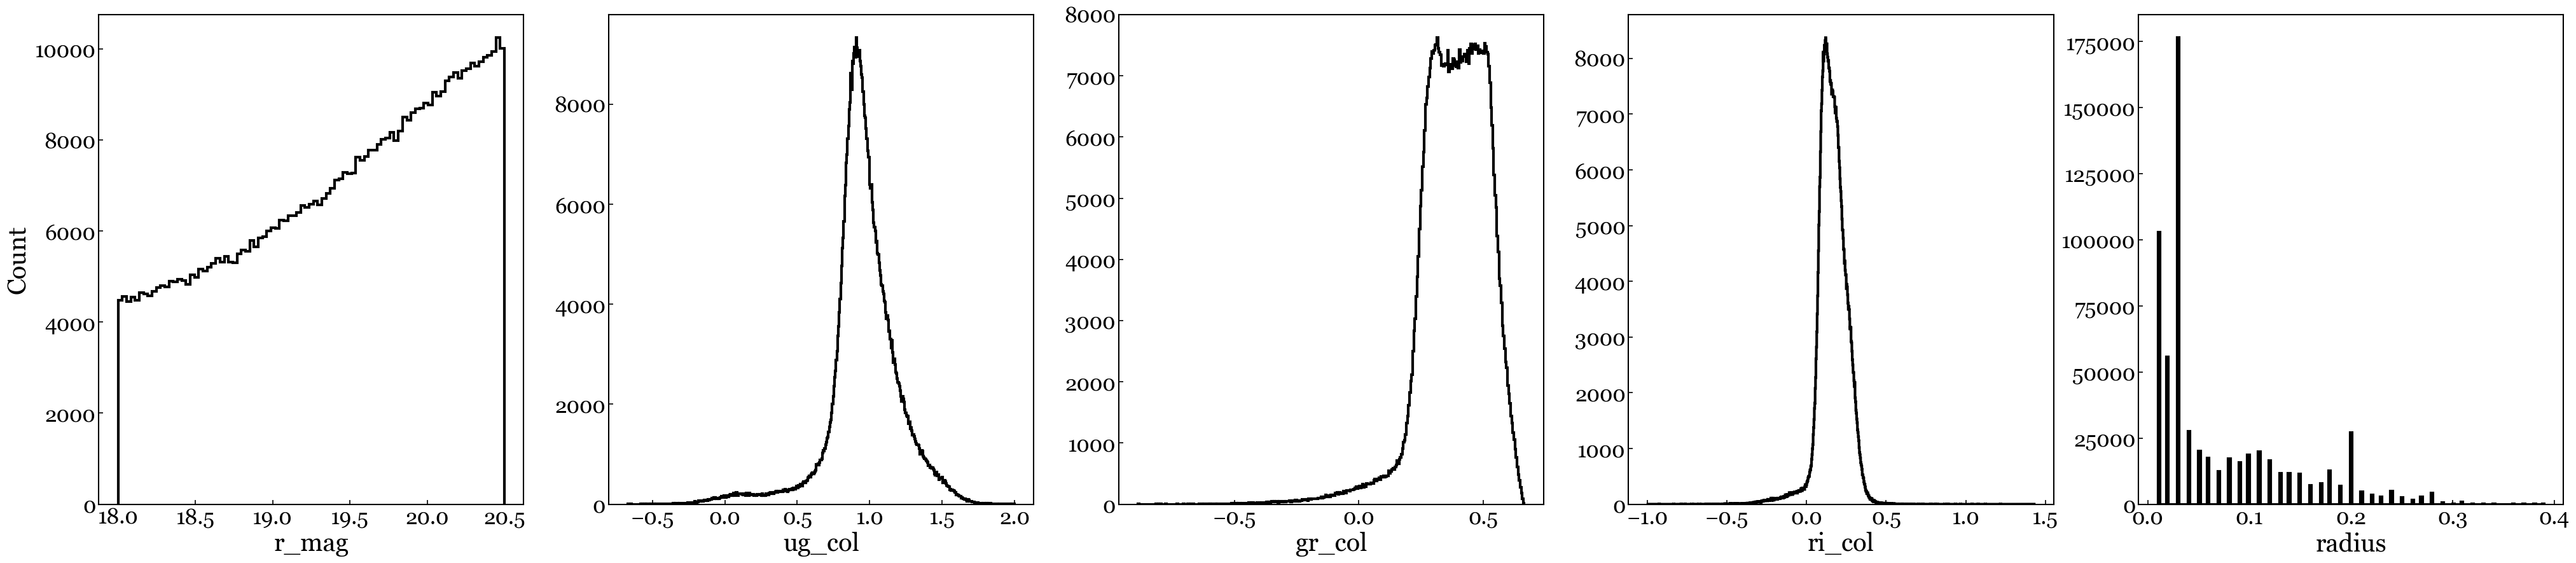

In [82]:
data_dim = SOM.data_dim

fig = plt.figure(figsize = (10 * data_dim, 10))

for i in range(data_dim):
    ax = fig.add_subplot(1, data_dim, i + 1)

    ax.hist(SOM.data[:, i], bins = 'auto',
            histtype = 'step', color = 'black', linewidth = 3)
    
    ax.set_xlabel(SOM.variable_names[i])

    if i == 0:
        ax.set_ylabel('Count')

In [86]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
| Initial rms error: 2.585


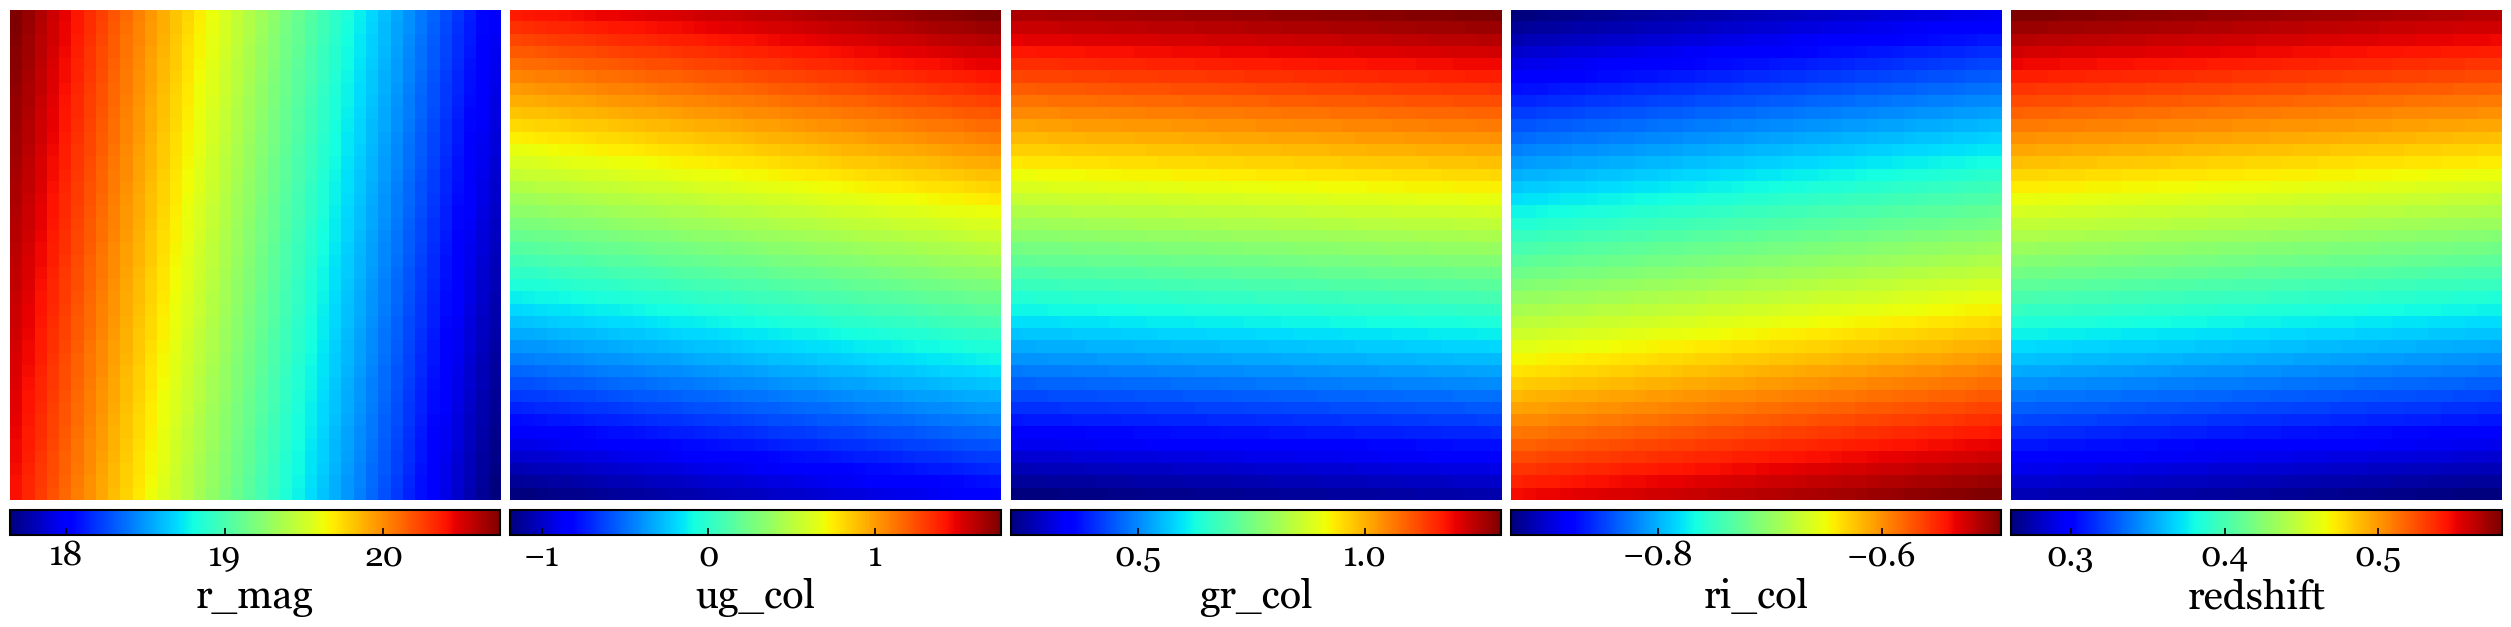

In [87]:
#Visualize SOM before training
SOM.show_map(cmap = 'jet')

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'| Initial rms error: {initial_quant_error:.3f}')

In [88]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.585                                   
Step 2 complete. Error: 0.370                                   
Step 3 complete. Error: 0.236                                   
Step 4 complete. Error: 0.181                                   
Step 5 complete. Error: 0.150                                   
SOM converged at step 5 to error 0.1501150431480672


0.1501150431480672


| SOM. Step 5. Initialization: pca


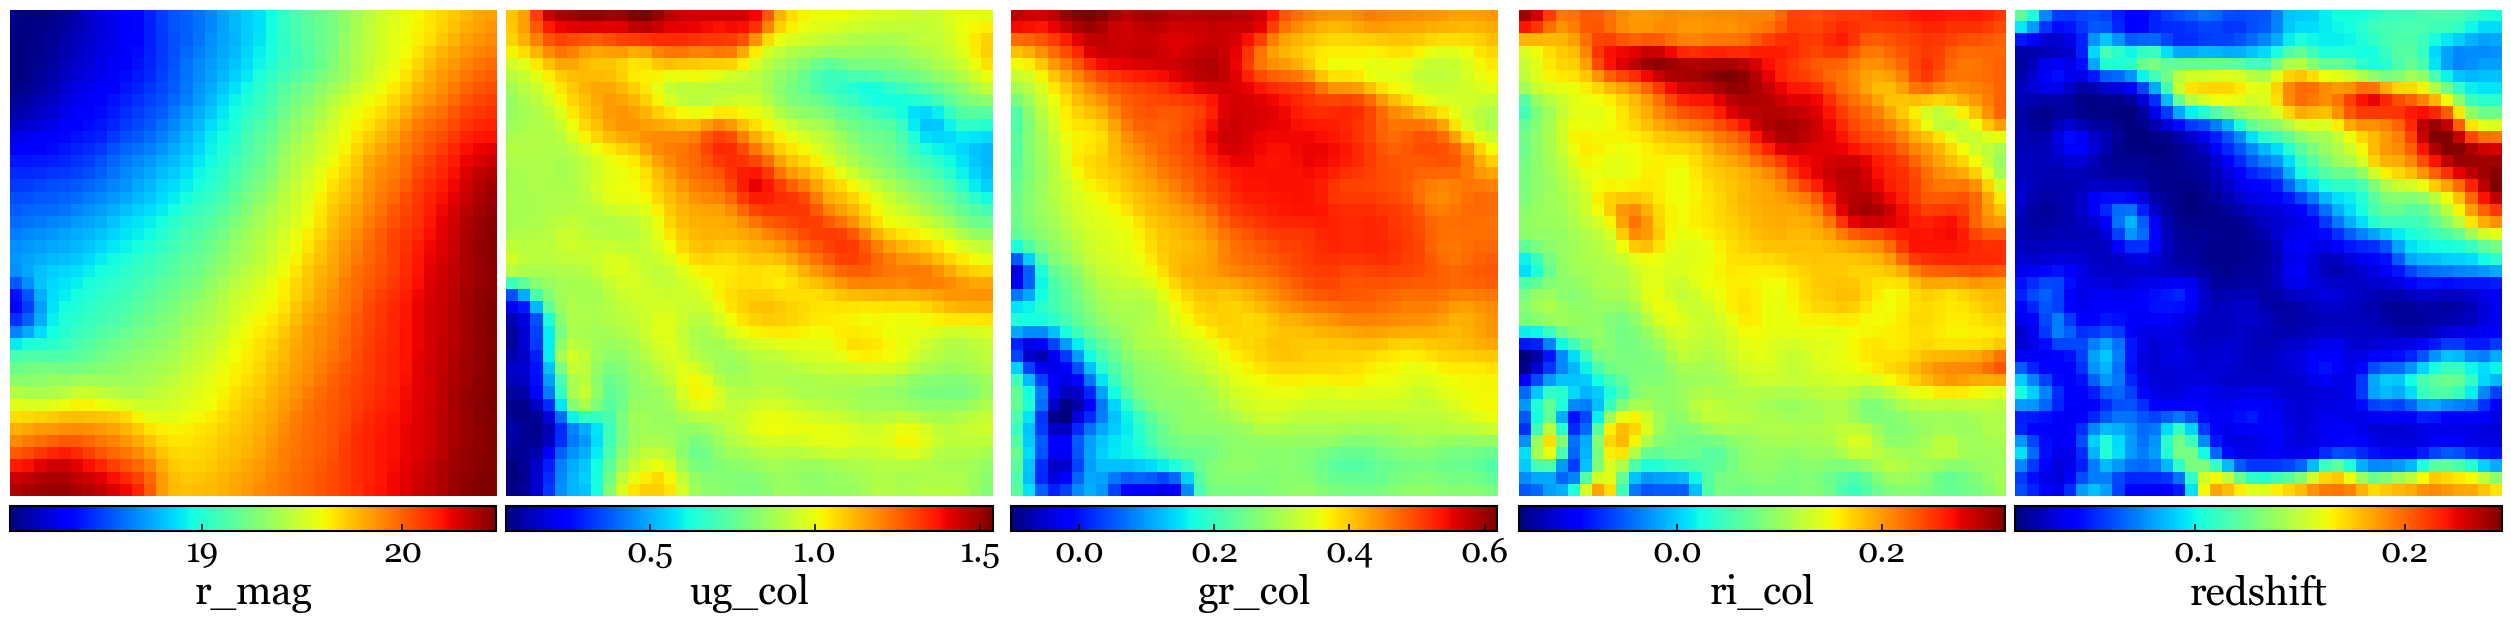

In [89]:
#Visualize the SOM after training | THIS MAKES PLOTS THAT LOOK LIKE THE WEATHER
SOM.show_map(cmap = 'jet')


| SOM. Step 5. Initialization: pca


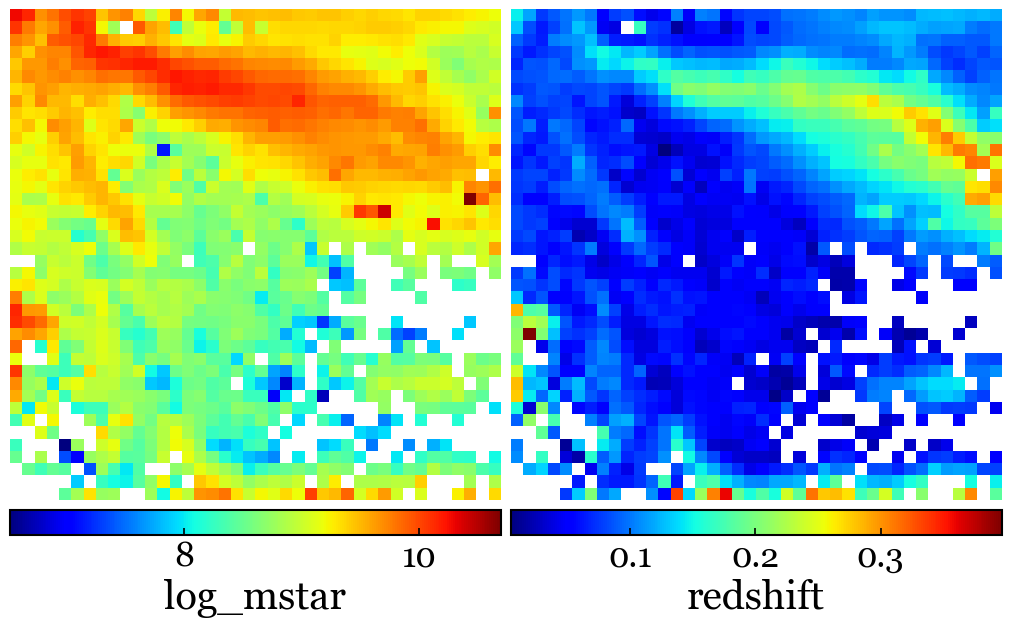

In [106]:
#Label the cells in the map with external parameters. Visualize the labeled map.
SOM.load_labeling_data(input_labels,
                       parameter_names = ['log_mstar', 'redshift'])
# SOM.normalize_labeling_data()

# input_label_stds['mstar_err'] = np.sqrt(input_label_stds['mstar_err'])
input_label_stds['mstar_err'] = 1

SOM.load_labeling_standard_deviations(input_label_stds)
# SOM.normalize_labeling_standard_deviations()

SOM.label_map()
# SOM.label_map(pdr = 1000,
#               sigmas_data= [0.1, 0.0075],
#               sigmas_add = [0, 0.0025])

SOM.show_map(show_labeled = True, log_norm = ['log_mstar'],
             cmap = 'jet')

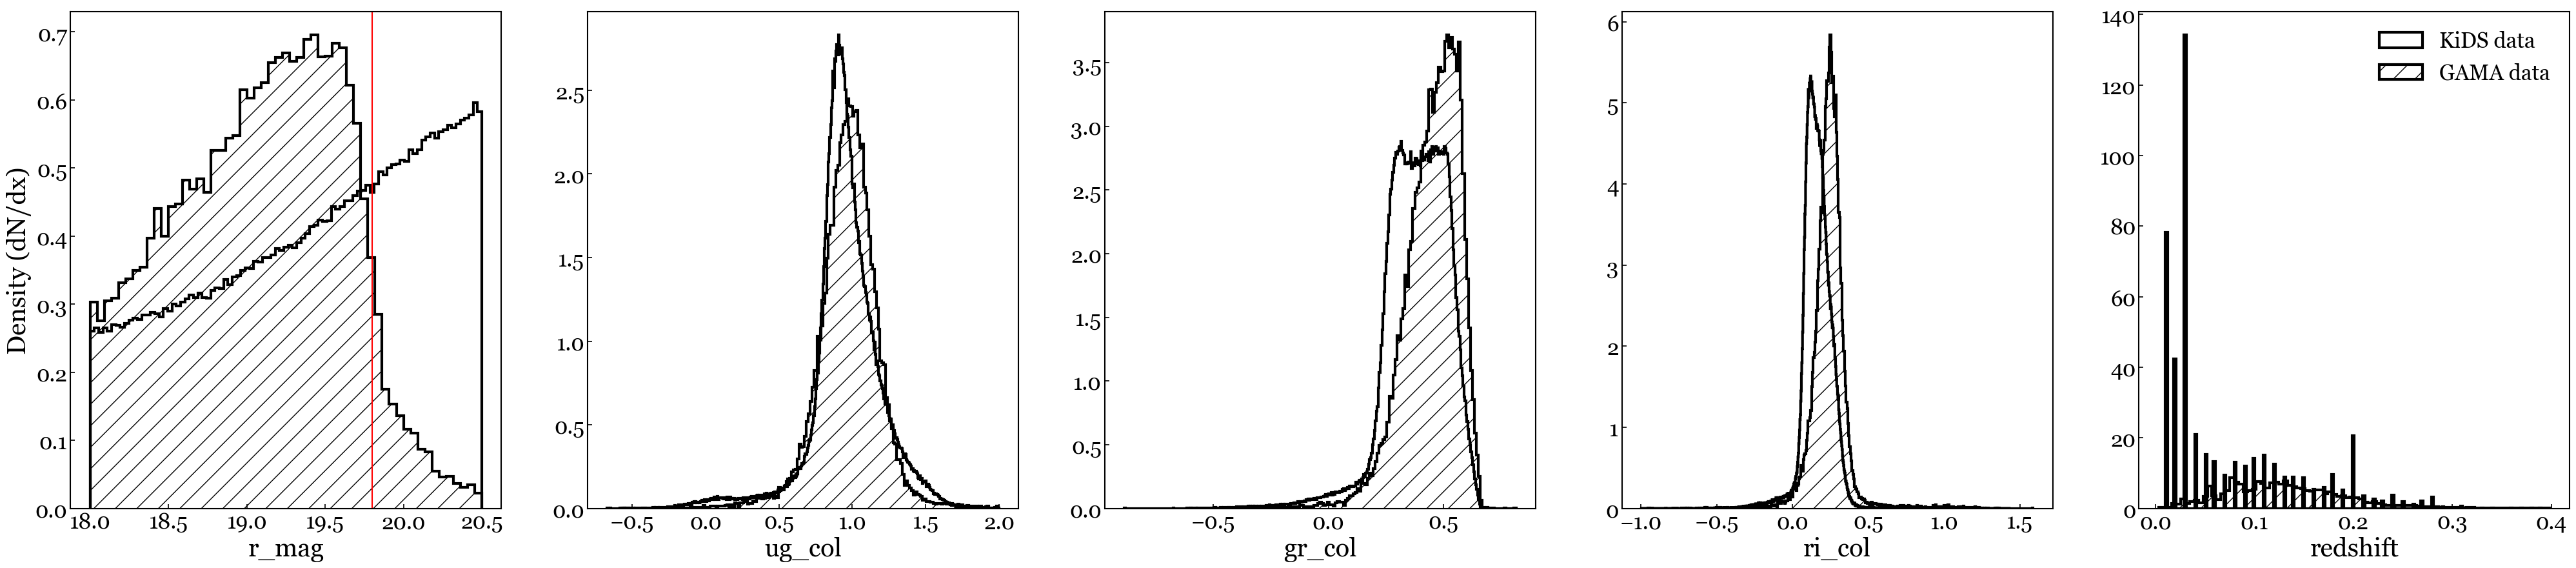

In [92]:
data_dim = SOM.data_dim

fig = plt.figure(figsize = (10 * data_dim, 10))

for i in range(data_dim):
    ax = fig.add_subplot(1, data_dim, i + 1)

    ax.hist(SOM.data[:, i], bins = 'auto', density = True,
            histtype = 'step', color = 'black', linewidth = 3,
            label = 'KiDS data')
    ax.hist(SOM.labeling_data[:, i], bins = 'auto', density = True,
            hatch = '/',
            histtype = 'step', color = 'black', linewidth = 3,
            label = 'GAMA data')
    
    ax.set_xlabel(SOM.variable_names[i])

    if i == 0:
        ax.set_ylabel('Density (dN/dx)')
        ax.axvline(19.8, color = 'red')

    if i == data_dim - 1:
        ax.legend(frameon = False)

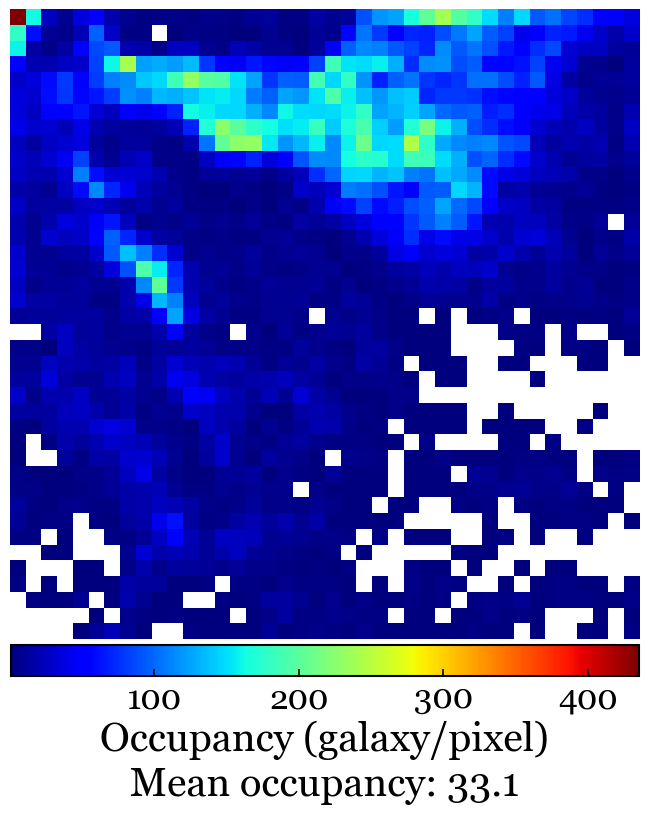

In [93]:
occupancy_map = np.full(SOM.mapsize, np.nan)
for cell, values in np.ndenumerate(SOM.labeled_map_values[..., 0, 0]):
    if len(values) > 0:
        occupancy_map[cell] = len(values)

fig = plt.figure(figsize = (9.6, 8), constrained_layout = True)
ax = fig.add_subplot()
occ_mp = ax.imshow(occupancy_map,
    origin = 'lower', cmap = 'jet')
# ax.set_title(f'Mean occupancy: {np.nanmean(occupancy_map):.1f}')
ax.axis('off')

fig.colorbar(mappable = occ_mp, location = 'bottom', fraction = 1, shrink = 0.66, pad = 0.005,
             label = f'Occupancy (galaxy/pixel)\nMean occupancy: {np.nanmean(occupancy_map):.1f}')

In [94]:
# SOM.predict(SOM.labeling_data[:, :SOM.data_dim],
#             np.sqrt(SOM.label_variances[:, :SOM.data_dim]))

In [107]:
SOM.predict(SOM.data,
            SOM.variances)

In [98]:
SOM.save_outputs('/data2/lsajkov/mpdg/saved_soms/18Jul24_KiDS_w_z',
                 save_weights = True, save_parameters = True)

In [99]:
np.save('/data2/lsajkov/mpdg/saved_soms/18Jul24_KiDS_w_z/prediction_results',
        SOM.prediction_results, allow_pickle = True)

In [100]:
np.save('/data2/lsajkov/mpdg/saved_soms/18Jul24_KiDS_w_z/labeling_data',
        SOM.labeling_data, allow_pickle = True)

In [101]:
np.save('/data2/lsajkov/mpdg/saved_soms/18Jul24_KiDS_w_z/labeled_map',
        SOM.labeled_map, allow_pickle = True)

In [102]:
np.save('/data2/lsajkov/mpdg/saved_soms/18Jul24_KiDS_w_z/labeled_map_values',
        SOM.labeled_map_values, allow_pickle = True)

___

Look at prediction results

In [108]:
mstar_pred = np.log10(SOM.prediction_results[:, 0])
redshift_pred = SOM.prediction_results[:, 1]

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_3405383/3539100413.py:17: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('log($M_*/M_{\odot}$)')


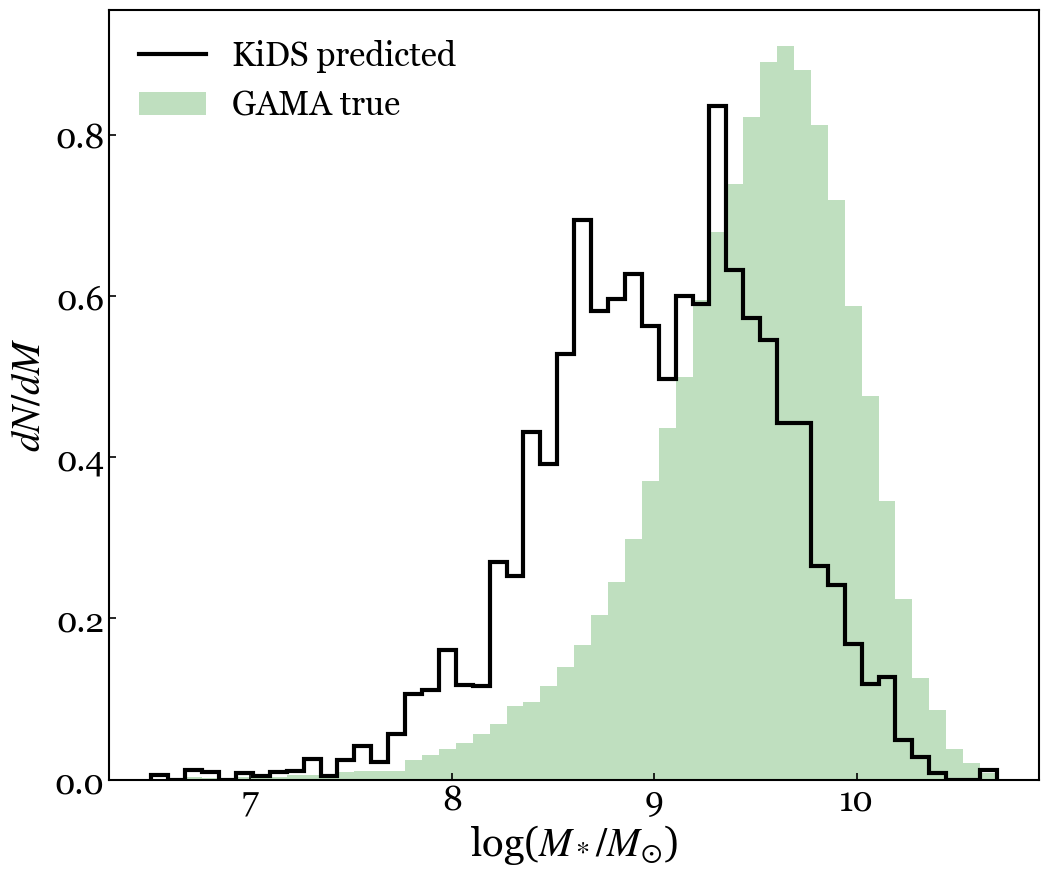

In [112]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

vals, bins = np.histogram(mstar_pred, bins = 50,
                          range = [np.nanmin(mstar_pred), np.nanmax(mstar_pred)],
                          density = True)

ax.stairs(vals, bins,
          color = 'black', linewidth = 3,
          label = 'KiDS predicted')

ax.hist(np.log10(SOM.labeling_data[:, SOM.data_dim + 0]),
        bins = bins, density = True, zorder = 0,
        color = 'green', alpha = 0.25,
        label = 'GAMA true')

ax.set_xlabel('log($M_*/M_{\odot}$)')
ax.set_ylabel('$dN/dM$')

ax.legend(frameon = False)

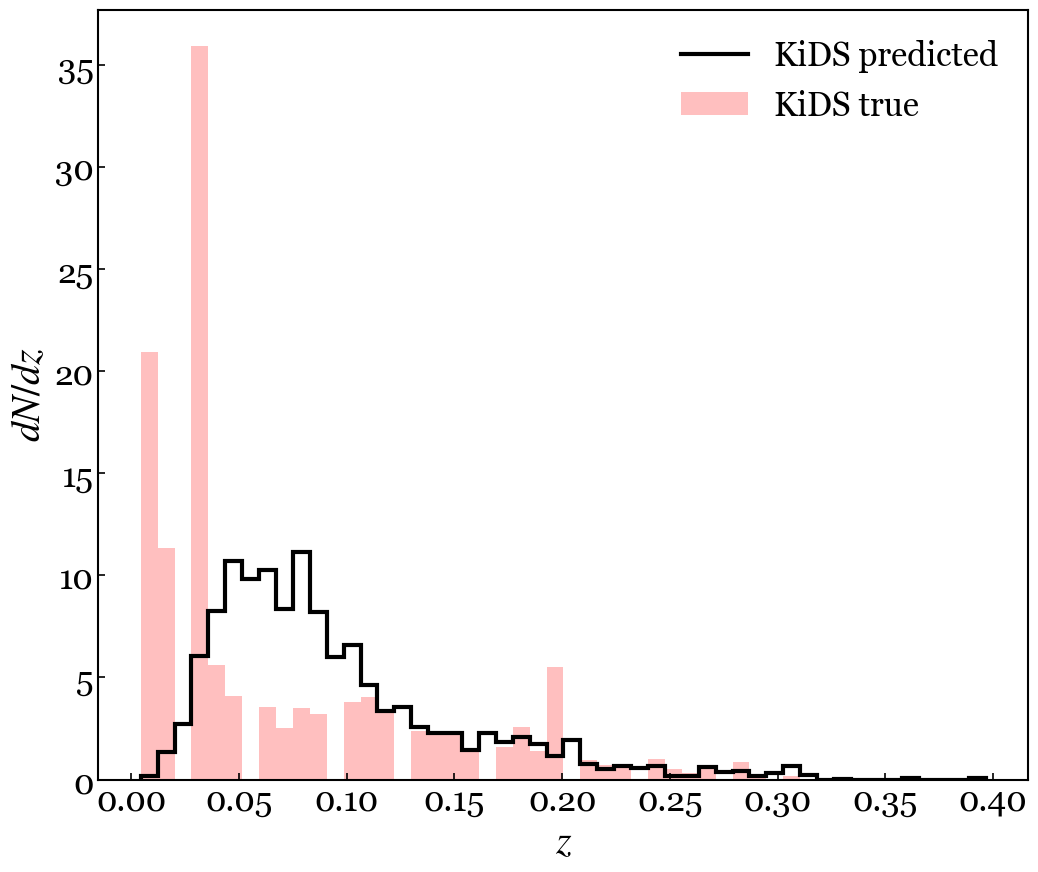

In [111]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

vals, bins = np.histogram(redshift_pred, bins = 50,
                          range = [np.nanmin(redshift_pred), np.nanmax(redshift_pred)],
                          density = True)

ax.stairs(vals, bins,
          color = 'black', linewidth = 3,
          label = 'KiDS predicted')

ax.hist(SOM.data[:, SOM.data_dim - 1],
        bins = bins, density = True, zorder = 0,
        color = 'red', alpha = 0.25,
        label = 'KiDS true')

# ax.hist(SOM.labeling_data[:, SOM.data_dim],
#         bins = bins, density = True, zorder = 0,
#         color = 'green', alpha = 0.25,
#         label = 'GAMA true')

ax.set_xlabel('$z$')
ax.set_ylabel('$dN/dz$')

ax.legend(frameon = False)

___

Compare predictions to inputs

<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_3405383/2138193404.py:28: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_3405383/2138193404.py:29: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_3405383/2138193404.py:37: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')
/var/tmp/lsajkov/ipykernel_3405383/2138193404.py:14: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the '

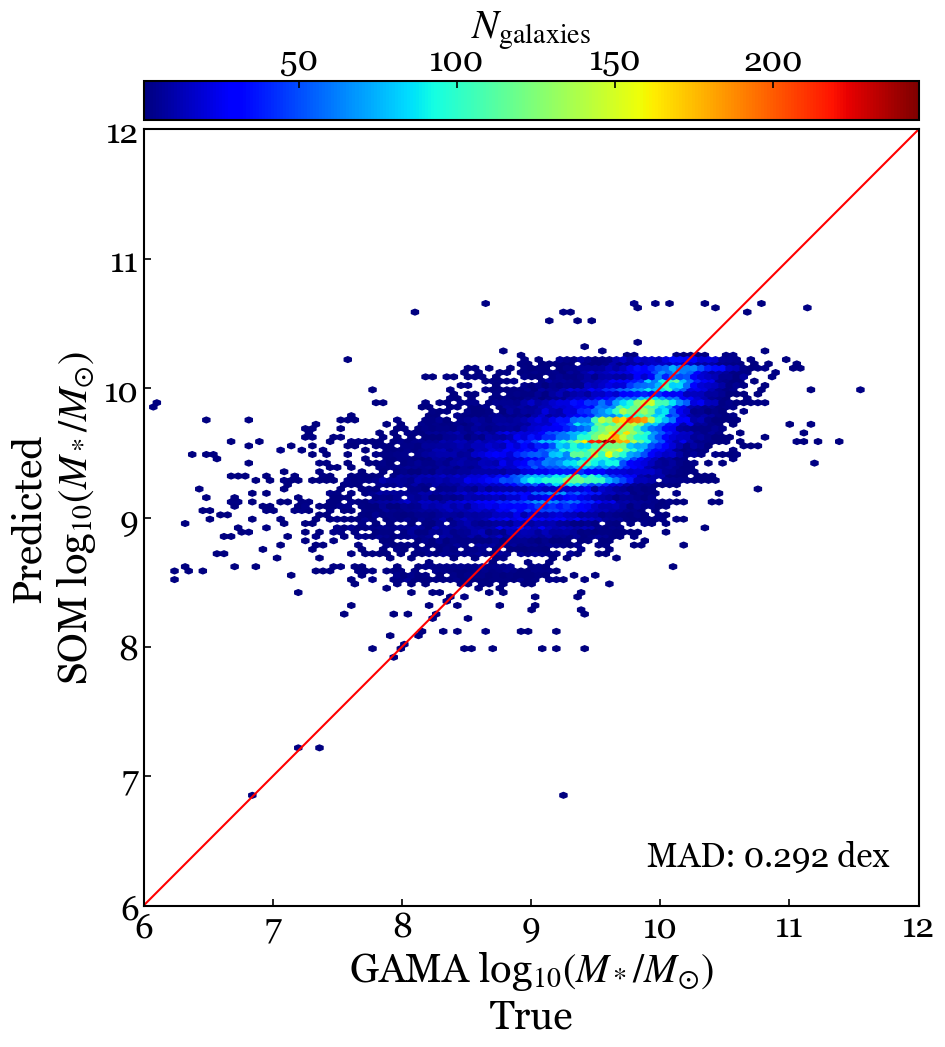

In [38]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

log = False

if log:
        hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim + 1],
                       SOM.prediction_results[:, 1],
                       mincnt = 1, cmap = 'jet')

        MAD = np.nansum(np.abs(SOM.labeling_data[:, SOM.data_dim] - SOM.prediction_results[:, 0]))/(len(SOM.prediction_results))

elif ~log:
        hb = ax.hexbin(np.log10(SOM.labeling_data[:, SOM.data_dim + 1]),
                       np.log10(SOM.prediction_results[:, 1]),
                       mincnt = 1, cmap = 'jet')

        MAD = np.nansum(np.abs(np.log10(SOM.labeling_data[:, SOM.data_dim + 1])\
                             - np.log10(SOM.prediction_results[:, 1])))/(len(SOM.prediction_results))

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(6, 12)
ax.set_ylim(6, 12)
ax.set_xticks(np.arange(6, 13, 1))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

ax.text(0.65, 0.05,
        f'MAD: {MAD:.3f} dex',
        transform = ax.transAxes)

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

MAD = np.nansum(np.abs(SOM.labeling_data[:, SOM.data_dim] - SOM.prediction_results[:, 0]))/(len(SOM.prediction_results) - np.sum(np.isnan(SOM.prediction_results), axis = 0)[0])

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][lo_stripe_idx],
#            SOM.prediction_results[:, 1][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][hi_stripe_idx],
#            SOM.prediction_results[:, 1][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([0, 0], slope = 1, color = 'red')

ax.set_xlim(0, 0.405)
ax.set_ylim(0, 0.405)
ax.set_yticks(np.arange(0, 0.5, 0.1))

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

ax.text(0.65, 0.05,
        f'MAD: {MAD:.3f} dex',
        transform = ax.transAxes)

# ax.axhline(0.33, color = 'black')
# ax.axvline(0.33, color = 'black')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
SOM_zs = SOM.prediction_results[:, 1]

lo_stripe_idx = (SOM_zs < 0.4) & (SOM_zs > 0.35)
hi_stripe_idx = (SOM_zs < 0.6) & (SOM_zs > 0.5)

hi_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][hi_stripe_idx]['r_mag']
lo_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][lo_stripe_idx]['r_mag']

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(lo_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'green', linewidth = 5)

ax.set_xlabel('$r$-magnitude')

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(hi_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'red', linewidth = 5)

ax.set_xlabel('$r$-magnitude')